## Genetic Algorithm


In [290]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify, simplify
import time
import copy


### Obtaining the data

In [291]:
doc2 = open("C:/Users/antoc/Downloads/PortableGit/practica2024/hub_data.txt")
lineas2 = doc2.readlines()

# Dividing each line into different columns using a space for separation.
datos_separados2 = [linea.strip().split(' ') for linea in lineas2]

datos= []
for fila in datos_separados2:
    datos.append(fila)

z = []
for i in range(len(datos)):
      a = float(datos[i][0])
      z.append(a)
z =np.array(z)

H = []
for i in range(len(datos)):
   if datos[i][1] == '':
      a = float(datos[i][2])
      H.append(a)
   else:
      a = float(datos[i][1])
      H.append(a)
H = np.array(H)

desv = []
for i in range(len(datos)):
    a = float(datos[i][2])
    desv.append(a)


### Objective

The algorithm minimizes the $\chi^2 = \sum_{i=1}^{N} (\dfrac{y_i - f(x_i)}{\sigma_{i}})^2$ with the objective of obtaining the function $f(x)$ that best fit the data. 

In [292]:
def polix(x):
    return x**x
def poli1(x):
    return (x+1) 
def poli2(x):
    return x**2
def poli3(x):
    return x**3

# Create list with coefficients
coeficientes = [random.random() for i in range(5)]
# Create list with constant functions. Those are values between 0 and 1.
funciones_c = [lambda x, i=i: coeficientes[i] for i in range(5)]

# Initial grammar containing a list of initial functions.
grammar = [polix, poli1, poli2, poli3] + funciones_c
operaciones = ['+', '-', '*', '/']


In [293]:
# Calculate the $\chi^2$ from the initially entered functions.
'''
def chi_2_f(f):
    chi_2 = 0
    j = 0
    while j+1 <= len(H):
        chi_2 += np.sum(np.square((H[j] - f(z[j]))/desv[j]))
        j += 1
    return chi_2
'''
def chi_2_f(f):
    # Calcular las diferencias y cuadrados de las diferencias
    diff = (H - f(z)) / desv
    squared_diff = np.square(diff)

    # Sumar los cuadrados de las diferencias
    chi_2 = np.sum(squared_diff)

    return chi_2


### Combine initial functions.

The initial functions are combined with operations between them until a defined number of initial functions is reached. A number of initial functions were chosen because it will increase the number of individuals as crossover and mutation are applied to the initial functions ('longitud final').

In [294]:
def juntar_elementos_inicial(funciones, operaciones, longitud_final=50):
    final = []
    while len(final) < longitud_final * 3:
        random_funcion1 = random.choice(funciones)
        random_funcion2 = random.choice(funciones)
        random_operador = random.choice(operaciones)

        final.append(random_funcion1)
        final.append(random_operador)
        final.append(random_funcion2)

    #Create a list of sublists to represent the rows
    resultado_final_inicial = [final[i:i+3] for i in range(0, len(final), 3)]

    return resultado_final_inicial

# In order to print the initial functions, you can utilize:
#for fila in resultado_final_inicial:
#    print(fila)


### Transform the list into a function

In order to obtain the $\chi^2$, convertir_lista_a_str is defined to convert a list of functions (grammar) and strings (operations) into a function. If one function is next to another in the list of functions and operators, it means that the operation between them is composition of functions.

In [295]:

#The term "x" should be enclosed in parentheses to avoid confusion with other occurrences of "x" in the string.
def a_string(funcion):
    if funcion == polix:
        return '(x)**(x)'
    elif funcion == poli1:
        return '((x)+1)'
    elif funcion == poli2:
        return '(x)**2'
    elif funcion == poli3:
        return '(x)**3'
    for i in range(len(funciones_c)):
        if funcion == funciones_c[i]:
            return str(coeficientes[i])
    else:
        return str(funcion)

# 'pasar_a_funcion' turn a string into a function.
x = symbols('x')
def pasar_a_funcion(expresion):
    a_sympy = sympify(expresion)
    a_python = lambdify(x, a_sympy, 'numpy')
    return a_python

# composicion takes a list of functions as strings and creates the composition of those.
def composicion(lista):
    modi_int = a_string(lista[-1])
    #print(modi_int)
    for i in range(2,len(lista)+1):
        modi_ext = a_string(lista[-i])
        modi_int = modi_ext.replace('(x)', '('+ modi_int +')' )
    return modi_int

# convertir_lista_a_str takes a list of 
def convertir_lista_a_str(lista):
    string=''
    for i in range(len(lista)):
        if callable(lista[i]):
            if i != 0 and callable(lista[i - 1]):
                string = string
            elif i < len(lista) - 1 and callable(lista[i + 1]):
                compo = []
                for j in range(i, len(lista)):
                    if callable(lista[j]):
                        compo.append(lista[j])

                string += composicion(compo)
            
            else:  
                string += a_string(lista[i])
        else:
            string += lista[i]

    return string

#lista_prueba = [poli2, '+', poli1,'-',poli1, poli2, funciones_c[0] ,'-', poli1]
#funcion_prueba= convertir_lista_a_str(lista_prueba)
#print(funcion_prueba)

def convertir_lista_a_funcion(lista):
    string = convertir_lista_a_str(lista)
    func= pasar_a_funcion(string)
    return func


### Calculate the $\chi^2$ for the initial population and select the best functions.

- 'tasa_seleccion' defines the number of best functions that are going to survive.
- 'tasa_cruce' defines the number of functions that are going to survive even if they are not the best-fitting ones.

In [296]:
def mejores(resultado_final, tasa_seleccion = 0.2, tasa_cruce =0.3):
    chis =[]
    for fila in resultado_final:
        a = convertir_lista_a_funcion(fila)
        chi_combinaciones = chi_2_f(a)
        chis.append(chi_combinaciones)
    

    # It select the elements to combine
    cant_sobrevivientes = tasa_seleccion*len(chis)
    cant_sobreviv = int(cant_sobrevivientes)
    #print('Cantidad de sobrevientes:' , cant_sobreviv)

    # Number of the best elements(functions with the lower $\chi^2$).
    num_elementos = cant_sobreviv
    # Obtain the indices and values of the smallest elements in order.
    indices_valores_menores = sorted(enumerate(chis), key=lambda x: x[1])[:num_elementos]
    # Separate the indices and values into different lists.
    indices_menores, valores_menores = zip(*indices_valores_menores)

    f_mejores= []
    for numero in indices_menores:
        f_mejores.append(resultado_final[numero])


    ''' 
    Allowing some offspring, even if less favorable, to survive. 
    This is because one mutation i may be bad, but the i+1 mutation could be better.
    '''

    # Get the indices and values of the not-so-small elements in order.    
    indices_valores_mayores = sorted(enumerate(chis), key=lambda x: x[1])[num_elementos:]
    # Separate the indices and values into different lists.
    indices_mayores, valores_mayores = zip(*indices_valores_mayores)
    for numero in indices_mayores:
        probabilidad = random.random()
        if probabilidad < tasa_cruce:
            f_mejores.append(resultado_final[numero])

    return f_mejores, valores_menores


### Crossover

Combine random parts of the solutions from the parents (composition of functions and addition, multiplication, etc., with each other). 

The selection is used to let through a certain percentage, which will have to mate and mutate. That is, the number decreases with the selection but increases with the crossover and mutation. For each crossover element, a number offspring are produced as a result of combinations with other parents ('hijos_por_padre').

The best element remains constant.

In [297]:
def a_combinar(padres, hijos_por_padre = 4):
    # Create a list with 6 random equations of the best functions to combine.
    combinar = [random.choice(padres) for i in range(hijos_por_padre)]

    # Separate functions and operations for each function to be combined with the selected one.
    combinar_con = []
    for k in range(len(combinar)):
        # 'funciones_combinar' is a list wih the functions to combine.
        funciones_combinar = []
        for j in range(len(combinar[k])):
            if callable(combinar[k][j]):  # Check if it is a function.
                funciones_combinar.append(combinar[k][j])


        # For each equation, choose a function from the list of functions for that equation
        combinar_con.append(random.choice(funciones_combinar)) # Choose a function from the available ones

    return combinar_con



def crossover(padres, hijos_por_padre = 4):
    hijos = []
    hijos.append(padres[0])
    for i in range(1, len(padres)):

        # If the length of the parents is less than a limit (15), add elements; if it is greater, change elements.
        if len(padres[i]) <= 15:
            # Add a combined operator and function, a combined function, or replace it with that of another parent for each offspring.
            numero_random = [random.randint(0,1) for i in range(hijos_por_padre)]
            for k in range(hijos_por_padre):
                hijos_ = copy.deepcopy(padres[i])
                if numero_random[k] == 0:
                    random_operador = random.choice(operaciones)
                    hijos_.append(random_operador)
                    hijos_.append(a_combinar(padres, hijos_por_padre)[k])
                else:
                    hijos_.append(a_combinar(padres, hijos_por_padre)[k])
            
                # Add the offspring to the final list.
                hijos.append(hijos_)


        else:
            for k in range(hijos_por_padre):
                hijos_ = copy.deepcopy(padres[i])
                random_operador = random.choice(operaciones) 
                #j is the index of an element in 'hijos_'.
                j = random.randint(0, len(hijos_)-1)
                if callable(hijos_[j]):
                    hijos_[j] = a_combinar(padres, hijos_por_padre)[k]
                else:
                    hijos_[j] = random_operador
                    hijos_[j+1] = a_combinar(padres, hijos_por_padre)[k]
                
                # Add the offspring to the final list.
                hijos.append(hijos_)

    return hijos

### Mutation

- 'tasa_mutación' defines the probability of mutation.

This mutates one operation for another and one function for another. The best elements remains constant.

In [298]:
def mutar(padres, tasa_mutacion= 0.05):
    hijos = copy.deepcopy(padres)
    for lista in hijos:
        for i in range(1, len(lista)):
            # Generates a number between 0 y 1
            probabilidad = random.random()

            # Verifying if the random number is lower than the desired probability
            if probabilidad < tasa_mutacion:
                if callable(lista[i]):
                    lista[i] = random.choice(grammar)
                else:
                    lista[i] = random.choice(operaciones)
    return hijos



### Recurrence

In [299]:
chi_por_generaciones = []
def recurrencia(gener):
    poblacion_inicial = juntar_elementos_inicial(grammar, operaciones, longitud_final= 50)

    # Measure the execution time of the function.
    inicio_tiempo = time.time() 

    # Best functions from the initial population.
    mejores_inicial = mejores(poblacion_inicial, tasa_seleccion = 0.2, tasa_cruce =0.3)[0]

    generaciones =0
    while generaciones <= gener:
        generaciones +=1
                
        # Obtain the best functions from the enhanced population.
        mejor_func_chi= mejores(mutar(crossover(mejores_inicial, hijos_por_padre= 4),  tasa_mutacion= 0.05), tasa_seleccion = 0.2, tasa_cruce =0.3)

        mejores_actual = mejor_func_chi[0]
        chi_mejores = mejor_func_chi[1]
        mejores_inicial = mejores_actual
        
        mejores_str = []
        for i in range(len(mejores_actual)):
            mejores_str.append(convertir_lista_a_str(mejores_actual[i]))

        if len(mejores_str)>= 50:
            mejores_actual = mejores_actual[:30]
            mejores_inicial = mejores_actual


        #print(f"Mejores funciones en esta iteración: {mejores_str}")
        #print(f"Largo mejores funciones en esta iteración: {len(mejores_str)}")
        #print(f"Chi^2: {chi_mejores}")
        print(f"generación: {generaciones}")
        
        # The best chi value for each generation is added to a list.
        chi_por_generaciones.append(chi_mejores[0])
        #print(f"Chi^2 por generación: {chi_por_generaciones}")

    fin_tiempo = time.time()

    tiempo_total = fin_tiempo - inicio_tiempo
    print(f"El tiempo de ejecución fue: {tiempo_total} segundos")

    return mejores_str, chi_por_generaciones

# 'generaciones_evaluar' are the number of generations for the algorithm.
generaciones_evaluar = 20
recu = recurrencia(generaciones_evaluar)


generación: 1


<lambdifygenerated-334753>:2: RuntimeWarning: overflow encountered in power
  return (x**3*x**(-x)*(x**(3*x))**(x**(3*x)))


generación: 2
generación: 3
generación: 4
generación: 5
generación: 6
generación: 7
generación: 8
generación: 9
generación: 10
generación: 11
generación: 12
generación: 13
generación: 14


<lambdifygenerated-336483>:2: RuntimeWarning: overflow encountered in power
  return (x**3*(x**9)**(x**9) + 45.335483822602234*x + 45.335483822602234)


generación: 15
generación: 16
generación: 17
generación: 18
generación: 19
generación: 20
generación: 21
El tiempo de ejecución fue: 10.021820545196533 segundos


['((x)+1)*((x)+1)/0.1501842098271845+((0.022967513114192983)+1)+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.1501842098271845-0.1501842098271845+((x)+1)/(0.1501842098271845)**2', '((x)+1)*((x)+1)/0.1501842098271845-0.1501842098271845+((x)+1)/(0.1501842098271845)**2', '((x)+1)*((x)+1)/0.1501842098271845+0.1501842098271845+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.1501842098271845-(0.1501842098271845)**2+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.1501842098271845-0.022967513114192983+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.1501842098271845-0.022967513114192983+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.1501842098271845-0.022967513114192983+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.1501842098271845-0.022967513114192983+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.1501842098271845-0.022967513114192983+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.1501842098271845-0.1501842098271845+((x)+1)/0.022967513114192983', '((x)+1)*((x)+1)/0.15018

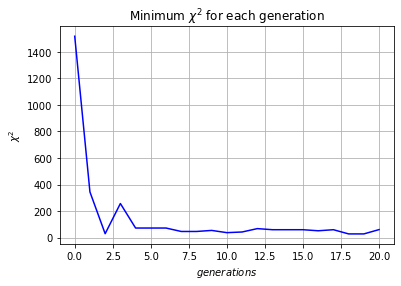

In [300]:
# 'funciones_finales' is a list with all the functions that best fit the data as a strings.
funciones_finales = recu[0]
# 'chis_finales' is a list with the minimum values of $\chi^2$.
chis_finales = recu[1]
print(funciones_finales)
print(f"Menor chi^2: {recu[1][-1]}")

z_chis= np.linspace(0, generaciones_evaluar, generaciones_evaluar + 1)
plt.xlabel('$ generations $')
plt.ylabel('$ \chi^2 $')
plt.title('Minimum $\chi^2$ for each generation')
plt.plot(z_chis,chis_finales, color = 'blue')
plt.grid(True)
plt.show()

In [301]:
'''
In order to graph the theoretical function, H(z) is defined.
'''

#Parameters
omega_r = 8.4e-5
omega_l = 0.7 - omega_r
omega_0 = 1
omega_m = 0.3
omega_k = 1 - omega_m - omega_r - omega_l

H_0= 70


#Creating the theoretical function
array_z = np.array(z)

def H_t(z):
    return H_0* ((omega_r * (1+z)**4) + omega_m * (1+z)**3 + omega_l + omega_k* (1+z)**2)**(1/2)

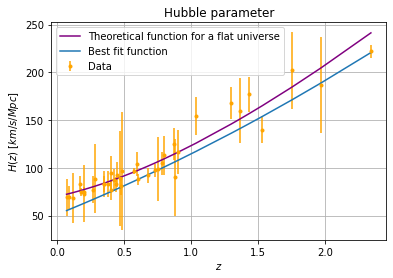

In [302]:
# Obtaining the best fit functions.
best_fit = []
for string in funciones_finales:
    a= pasar_a_funcion(string)
    best_fit.append(a)

yerr = desv
plt.xlabel('$ z $')
plt.ylabel('$ H(z)$ $[km/s/Mpc] $')
plt.title('Hubble parameter')

omega_0 = 1
omega_k = 1 - omega_0
plt.plot(array_z, H_t(array_z), color = 'purple', label='Theoretical function for a flat universe')
plt.plot(z, best_fit[0](z), label= 'Best fit function')
#plt.plot(z, best_fit[1](z), label= 'Best fit function 2')
#plt.plot(z, best_fit[2](z), label= 'Best fit function 3')
#plt.plot(z, best_fit[3](z), label= 'Best fit function 4')

plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Data')
plt.legend()
plt.grid(True)
plt.show()


In [303]:
# Deriving the best-fit function as a string.
ec_final = funciones_finales[0]
x = symbols('x')
a_sympy = sympify(ec_final)
# Simplifying the ecuation
a_simpli = simplify(a_sympy)
a_python = lambdify(x, a_simpli, 'numpy')

print("Ecuación final obtenida:", ec_final)
print("Ecuación final simplificada:",a_simpli)

Ecuación final obtenida: ((x)+1)*((x)+1)/0.1501842098271845+((0.022967513114192983)+1)+((x)+1)/0.022967513114192983
Ecuación final simplificada: 6.6584896052034379*x**2 + 56.85673882774398*x + 51.221216735654735
